# MLS 8 - *Objective*

As organizations increasingly rely on complex algorithms to make critical decisions, ensuring the ongoing performance and reliability of these models has become paramount. Model monitoring is the practice of systematically observing, assessing, and managing machine learning models in production to detect anomalies, maintain their accuracy, and mitigate risks.

In this comprehensive guide, we will explore the fundamental concepts, challenges, and best practices of model monitoring. We will delve into the significance of continuous model evaluation, the detection of model drift and data drift. 

### Connect to the workspace

First, we'll need to connect to your Azure Machine Learning workspace. The Azure Machine Learning workspace is the top-level resource for the service. It provides you with a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We're using DefaultAzureCredential to get access to the workspace. This credential should be capable of handling most Azure SDK authentication scenarios.

In [2]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

from azure.ai.ml import command, Input

from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    CodeConfiguration
)

from azure.storage.blob import BlobServiceClient

Next, get a handle to the workspace by providing your Subscription ID, Resource Group name, and workspace name. To find these parameters:

* Look in the upper-right corner of the Azure Machine Learning studio toolbar for your workspace name.
* Select your workspace name to show your Resource Group and Subscription ID.
* Copy the values for Resource Group and Subscription ID into the code.

In [3]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="bd3b00cc-6c29-4334-a410-a29ae27f4b6e", #Provide your subscription ID as shown in the above screenshot
    resource_group_name="aftermidtermbreak1", #Provide your Resource Group as shown in the above screenshot
    workspace_name="afterbreak1",
)

### Create a compute resource to run the job

Azure Machine Learning needs a compute resource to run a job. This resource can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark.

We only need a basic cluster for this task; thus, we'll pick a Standard_D2_v3 model with 2 CPU cores and 7 GB RAM to create an Azure Machine Learning compute.



In [4]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

You already have a cluster named cpu-cluster, we'll reuse it as is.
AMLCompute with name cpu-cluster is created, the compute size is STANDARD_D2_V3


### Configure and submit your training job

#### Prepare the training script

In [5]:
# To use the training script, first create a directory where you will store the file.
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

**Next, create the script file in the source directory**

In [6]:
%%writefile {src_dir}/main.py

import os
import mlflow
import argparse

import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

def main():

    mlflow.start_run() # Start an MLflow run

    parser = argparse.ArgumentParser() # Create an argument parser
    parser.add_argument("--data", type=str)  # Add an argument for the data file path
    parser.add_argument("--learning-rate", required=False, default=0.1, type=float)
    parser.add_argument("--max-depth", required=False, default=4, type=float)
    parser.add_argument("--n-estimators", required=False, default=100, type=int)
    args = parser.parse_args()

    airbnb = pd.read_csv(args.data)

    from sklearn.model_selection import train_test_split
    X = airbnb.drop(columns=["price"])
    X = pd.get_dummies(X,drop_first=True)

    y = airbnb["price"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
    )
    # Create a Gradient Boosting Regressor model with the specified hyperparameters
    model_gbr = GradientBoostingRegressor(
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate,
        max_depth=args.max_depth
    )


    model_gbr.fit(X_train, y_train)

    rmse = model_gbr.score(X_test, y_test)

    mlflow.log_metric("RMSE", float(rmse))

    print("Registering model pipeline")
     # Log the trained model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_gbr,
        registered_model_name="gbr_airbnb_redictor",
        artifact_path="gbr_airbnb_predictor"
    )
    # End the MLflow run

    mlflow.end_run()


if __name__ == '__main__':
    main()



Overwriting ./src/main.py


**The inputs parameter specifies the input data **



In [7]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="azureml:airbnb_data:1", # The path to the input data file
        )),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python main.py --data ${{inputs.data}}",
    # Specify the environment to be used for the job
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster",
    # Specify the name of the experiment for the job
    experiment_name="airbnb_exper_test",
     # Specify the display name for the job
    display_name="airbnb_display_name",
)


#### Submit the job

In [8]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
airbnb_exper_test,clever_pig_n8q2rkmd28,command,Starting,Link to Azure Machine Learning studio


**Note 1: We can check the status and outcome of the training job by going to the "Jobs" on the left --> Metrics.**

**Note: What happens during job execution: **

As the job is executed, it goes through the following stages:

* **Preparing**: A docker image is created according to the environment defined. The image is uploaded to the workspace's container registry and cached for later runs. Logs are also streamed to the run history and can be viewed to monitor progress. If a curated environment is specified, the cached image backing that curated environment will be used.

* **Scaling**: The cluster attempts to scale up if the cluster requires more nodes to execute the run than are currently available.

* **Running**: All scripts in the script folder src are uploaded to the compute target, data stores are mounted or copied, and the script is executed. Outputs from stdout and the ./logs folder are streamed to the run history and can be used to monitor the run.



### Find and register the model

In [9]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes, InputOutputModes

model_name = "gbr_airbnb_redictor_v2"

model = Model(
    name=model_name,
    #The name of the MLflow model.
    path="gbr_airbnb_redictor/gbr_airbnb_predictor",
    #Path to the root directory of the model.
    type=AssetTypes.MLFLOW_MODEL,
    #The type of the model asset(MLflow model).
    description="MLflow model for the airbnb problem",
    #The purpose of the model.
)

We can then register this model.

In [10]:
registered_model = ml_client.models.create_or_update(model=model)

#### Import the required libraries

In [11]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

#### Create Online Endpoint

Online endpoints are endpoints that are used for online (real-time) inferencing. Online endpoints contain deployments that are ready to receive data from clients and can send responses back in real time.

To create an online endpoint we will use `ManagedOnlineEndpoint`. This class allows user to configure the following key aspects such as `name`,`auth_mode`,`identity`,etc.


#### Configure the endpoint

In [12]:
# Importing the required modules
import random
import string

# Creating a unique endpoint name by including a random suffix

# Defining a list of allowed characters for the endpoint suffix
allowed_chars = string.ascii_lowercase + string.digits

# Generating a random 5-character suffix for the endpoint name by choosing
# characters randomly from the list of allowed characters
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))

# Creating the final endpoint name by concatenating a prefix string
# with the generated suffix string
endpoint_name = "airbnb-endpoint-" + endpoint_suffix


In [13]:
print(f"Endpoint name: {endpoint_name}")

Endpoint name: airbnb-endpoint-em3wj


In [14]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,  
    # Name of the endpoint, should be unique within your deployment
    description="An online endpoint serving an MLflow model for the pima classification task",
    # A string describing the purpose of the endpoint
    auth_mode="key",
    # Authentication mode to use for the endpoint (in this case, using an API key)
    tags={"foo": "bar"},
    # A dictionary of key-value pairs that can be used to tag the endpoint
)

#### Create the endpoint
Using the `MLClient` created earlier, we will now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

In [15]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://airbnb-endpoint-em3wj.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://airbnb-endpoint-em3wj.eastus.inference.ml.azure.com/swagger.json', 'name': 'airbnb-endpoint-em3wj', 'description': 'An online endpoint serving an MLflow model for the pima classification task', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/bd3b00cc-6c29-4334-a410-a29ae27f4b6e/resourcegroups/aftermidtermbreak1/providers/microsoft.machinelearningservices/workspaces/afterbreak1/onlineendpoints/airbnb-endpoint-em3wj', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/bd3b00cc-6c29-4334-a410-a29ae27f4b6e/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:eac353ba-11c6-4ebe-9412-e65153b26bd1:a0ff94d6-c3cb-4d6f-bd5e-4ce69563c179?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions

#### Create a blue deployment

A deployment is a set of resources required for hosting the model that does the actual inferencing. We will create a deployment for our endpoint using the `ManagedOnlineDeployment` class. This class allows user to configure key aspects.

##### Curating the deployment script:

**Go to the Microsoft Azure home page and search for Application Insights --> Copy the Connection String and use it in the score.py script.**

In [16]:
%%writefile {src_dir}/score.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=a23cf01d-b152-4a13-ab5e-816cf7529c98;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "gbr_airbnb_predictor")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json.dumps(json_data["input_data"])
    data = infer_and_parse_json_input(serving_input, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()


Overwriting ./src/score.py


**Curating the deployment:**

In [17]:
# Create a new deployment with name "blue"
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    # Use the previously generated endpoint name
    endpoint_name=endpoint_name,
    # Use the registered model
    model=registered_model,
    # Use the latest environment
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    # Use a single instance of type "Standard_E2s_v3"
    instance_type="Standard_E2s_v3",
    instance_count=1,
    # Enable Application Insights for the deployment
    app_insights_enabled=True,
)

#### Create the deployment

Using the `MLClient` created earlier, we will now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [18]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint airbnb-endpoint-em3wj exists


..........................................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'provisioning_state': 'Succeeded', 'endpoint_name': 'airbnb-endpoint-em3wj', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/bd3b00cc-6c29-4334-a410-a29ae27f4b6e/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/od:eac353ba-11c6-4ebe-9412-e65153b26bd1:8ba5344f-7444-41c6-b2a7-963f7b9b5144?api-version=2023-04-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/bd3b00cc-6c29-4334-a410-a29ae27f4b6e/resourceGroups/aftermidtermbreak1/providers/Microsoft.MachineLearningServices/workspaces/afterbreak1/onlineEndpoints/airbnb-endpoint-em3wj/deployments/blue', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/computemidtermbk1/code/Users/ghenexyisims', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x7f6fbc439d50>, 'mod

#### Test the deployment

Using the `MLClient` created earlier, we will get a handle to the endpoint. The endpoint can be invoked using the invoke command.

We will send a sample request using a "sample_data.json"file.

In [19]:
model_predictions_azure = ml_client.online_endpoints.invoke(
        endpoint_name=endpoint_name,# Specify the name of the endpoint to invoke
        deployment_name="blue",
        request_file="sample_data.json"   # Provide the file containing the sample data for making predictions
)

**Note:**

1. For connection string, Go to "Storage account" --> "Access Keys" --> Copy any of the connection string

2. For directory path, Go to "Storage account" --> "Containers" --> "insights-logs-apprequests" --> Copy the path

#### ****LEAVE THE NEXT 4 CODES. HE DIDNT HAVE SUCH CODES IN HIS OWN VIDEO

In [19]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=azureml2318851154;AccountKey=W7S/j9WG740+YB6sjR90zXNpoinJ7wC/QUSDJUEadjDWDCDvTPRmCD5VGDLmc9+6y5C14xFhUOgY+AStqzEU4A==;EndpointSuffix=core.windows.net'
container_name = 'insights-logs-apprequests'
directory_path = "resourceId=/SUBSCRIPTIONS/1C6D9EF7-1867-436F-986F-F37C475A295B/RESOURCEGROUPS/TESTML/PROVIDERS/MICROSOFT.INSIGHTS/COMPONENTS/AZUREML9306741456/y=2023/m=07/d=19/h=12/m=00/PT1H.json"

In [20]:
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs(name_starts_with=directory_path)

In [21]:
for blob in blobs:
    blob_client = container_client.get_blob_client(blob=blob.name)
    prediction_data_raw = blob_client.download_blob().readall().decode('utf-8')
    break

In [22]:
import json
for pred in prediction_data_raw.split('\n'):
    if pred != '':
        prediction_data = json.loads(pred)
        model_predictions_azure_ = json.loads(prediction_data['Properties']['Response Value'])
        break

LEAVE THE 4 CODES ABOVE****.
### CONTINUE FROM CODE BELOW PLEASE

In [21]:
# Convert the string representation of predictions to a Python data structure
import ast
model_predictions_azure_list = ast.literal_eval(model_predictions_azure)

In [22]:
# Access the converted Python data structure
model_predictions_azure_list_2 = ast.literal_eval(model_predictions_azure_list)
model_predictions_azure_list_2

{'predictions': [4.917771115184389,
  5.027758386746959,
  4.789771447251503,
  5.08341918162953,
  4.917771115184389,
  4.895960743537982,
  4.903958299826744,
  5.003983980319411,
  5.006659664102707,
  4.911414327366942,
  4.903958299826744,
  4.865380688905286,
  5.015672694889259,
  4.974737483162194,
  4.947260488414247,
  4.889198042056494,
  4.790558937454378,
  4.793579353190135,
  4.8480890069033835,
  4.974737483162194,
  4.732285704640694,
  4.869383008003644,
  4.897809021701241,
  4.940876145715558,
  4.998961008489344,
  5.0482546921471645,
  4.830483861492196,
  4.853731188331763,
  4.830483861492196,
  4.655788816639369]}

In [23]:
# Access the converted Python data structure
model_predictions_azure_list_2 = ast.literal_eval(model_predictions_azure_list)
model_predictions_azure_list_2

{'predictions': [4.917771115184389,
  5.027758386746959,
  4.789771447251503,
  5.08341918162953,
  4.917771115184389,
  4.895960743537982,
  4.903958299826744,
  5.003983980319411,
  5.006659664102707,
  4.911414327366942,
  4.903958299826744,
  4.865380688905286,
  5.015672694889259,
  4.974737483162194,
  4.947260488414247,
  4.889198042056494,
  4.790558937454378,
  4.793579353190135,
  4.8480890069033835,
  4.974737483162194,
  4.732285704640694,
  4.869383008003644,
  4.897809021701241,
  4.940876145715558,
  4.998961008489344,
  5.0482546921471645,
  4.830483861492196,
  4.853731188331763,
  4.830483861492196,
  4.655788816639369]}

In [24]:
# Extract the predicted values from the dictionary and convert them to a list or array-like object
predicted_values = model_predictions_azure_list_2['predictions']

### Target Check

This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

In [25]:
#Access the training data
import pandas as pd
training_data = pd.read_csv("airbnb.csv")

In [26]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
#General imports required for testing
import json
import ast

import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

In the plots below, we compare the distribution of predictions from the endpoint logs with the distribution of the target in the training data.

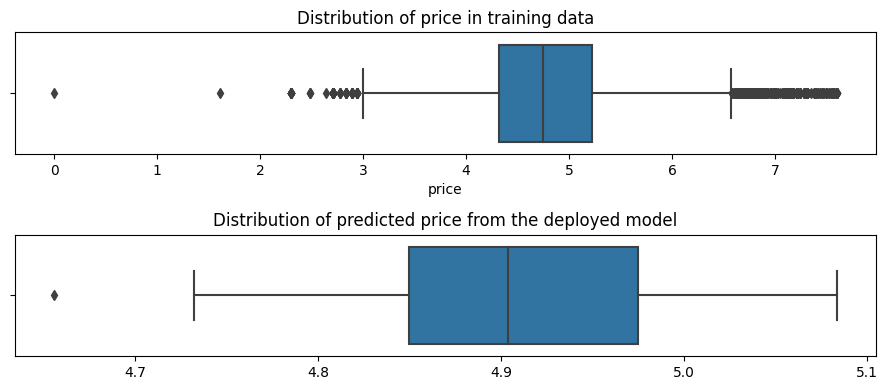

In [28]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='price', data=training_data)
plt.title("Distribution of price in training data")
plt.subplot(212)
sns.boxplot(x=predicted_values)
plt.title("Distribution of predicted price from the deployed model")
plt.tight_layout()

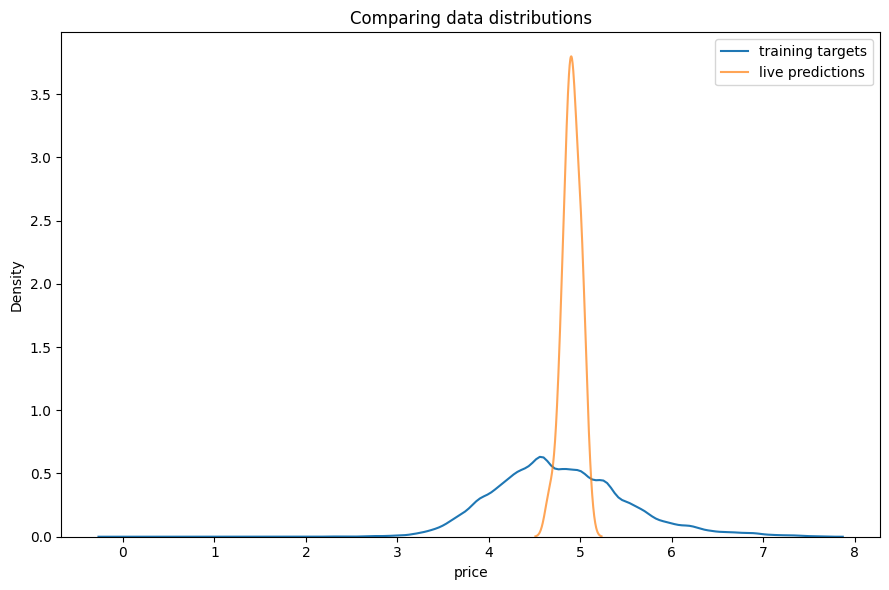

In [29]:
plt.figure(figsize=(9, 6))
sns.kdeplot(x='price', data=training_data, label='training targets')
sns.kdeplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing data distributions')
plt.tight_layout()

The plots hint at a difference between the predictions coming from the endpoint and the distribution of targets in the training data.

**Kolmogorov-Smirnov test**

To confirm the absence of target drift, we use the Kolmogorov-Smirnov (K-S) test. K-S test is a statistical method used to compare two probability distributions and determine if they significantly differ from each other. In the context of testing the difference between the distributions of model predictions and the distribution of targets in training data, the K-S test can help assess if there is any deviation or drift.

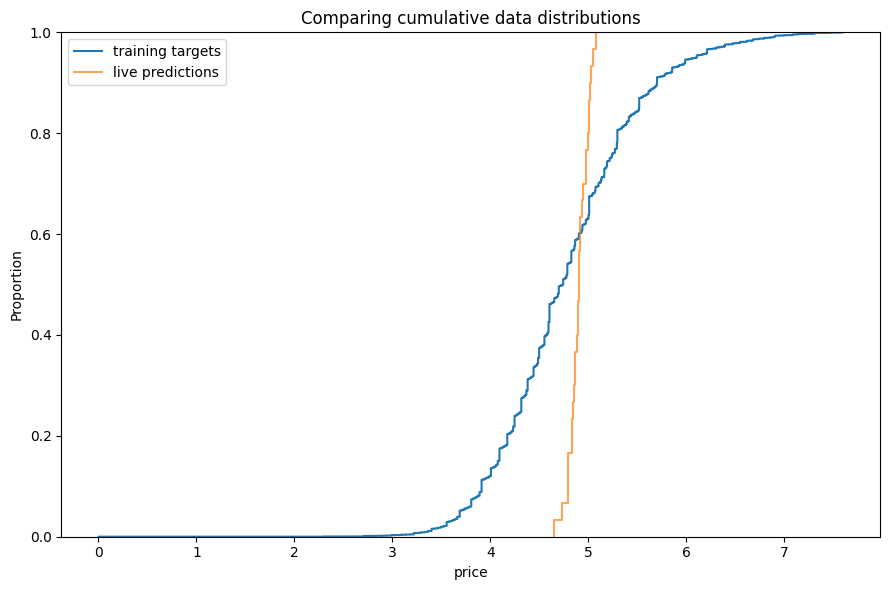

In [30]:
plt.figure(figsize=(9, 6))
sns.ecdfplot(x='price', data=training_data, label='training targets')
sns.ecdfplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing cumulative data distributions')
plt.tight_layout()

In [31]:
statistic, p_value = ks_2samp(
            training_data["price"].values, 
            predicted_values
)

In [32]:
p_value

1.0141435190392184e-06

Since the p-value is  <0.05 , we conclude there is a significant difference between the model predictions and the target distribution in the training data. This means that we will need to focus on those predictions where anomalies are observed and dig deeper into why these deviations were observed. A typical start point is at the outer edges of the predictions to probe why deviations exist.

## Data Drift

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems.

In [33]:
sample = pd.read_csv("synthetic_check.csv")

In [34]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  6823 non-null   int64  
 1   bathrooms                     6823 non-null   float64
 2   cleaning_fee                  6823 non-null   bool   
 3   review_scores_rating          6823 non-null   int64  
 4   bedrooms                      6823 non-null   int64  
 5   beds                          6823 non-null   int64  
 6   room_type_Private room        6823 non-null   bool   
 7   room_type_Shared room         6823 non-null   bool   
 8   cancellation_policy_moderate  6823 non-null   bool   
 9   cancellation_policy_strict    6823 non-null   bool   
 10  instant_bookable_t            6823 non-null   bool   
dtypes: bool(6), float64(1), int64(4)
memory usage: 306.6 KB


In [35]:
pd.crosstab(training_data['beds'], sample['beds'])

beds,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1,2453,917,319,146,75,30,10,15,3,5,3,4,2,1,0,0
2,1010,401,150,68,27,16,5,8,1,4,2,1,0,0,0,1
3,384,142,53,22,7,11,1,2,2,0,0,0,0,0,1,1
4,173,58,24,12,9,3,0,0,1,0,0,1,0,0,0,0
5,84,21,8,5,5,1,0,0,0,0,0,0,0,0,0,0
6,31,15,5,2,0,2,0,0,0,0,0,0,0,0,0,0
7,13,2,3,1,0,1,0,0,0,0,0,0,0,0,0,0
8,8,3,2,0,0,1,0,0,0,0,0,0,0,0,0,0
9,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
threshold = 0.05
features_with_data_drift = []

In [37]:
target = "price"
numeric_features = ['accommodates', 'bathrooms', 'review_scores_rating', 'bedrooms', 'beds']
categorical_features = ['room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable']

In [38]:
for k, feature in enumerate(sample.columns):
    # Check if the feature is numeric
    # Perform the Kolmogorov-Smirnov test between the corresponding feature in the training and sample data
    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values, 
            sample[feature].values
        )
        
        if p_value < threshold:
            features_with_data_drift.append(feature)
    # Check if the feature is categorical
    # Perform the chi-squared test between the corresponding feature in the training and sample data
    elif feature in categorical_features:
        statistic, p_value, dof, expected = chi2_contingency(
            pd.crosstab(
                training_data[feature], 
                sample[feature]
            ).values
        )
        # Add the feature to the list of features with data drift
        if p_value < threshold:
            features_with_data_drift.append(feature)

In [39]:
features_with_data_drift

['review_scores_rating']

This drift in review_scores_rating is potentially the reason why there is a drift in the predicted targets (e.g., outlier predictions). Once drift is detected, model retraining needs to be executed.

## Model Drift

To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth.

For regression problems where the ground truth is readily available, we can compare the model's performance on a random sample with the ground truth observed in that sample. This comparison utilizes a paired two-sample t-test since the exact same sample is presented to both the deployed model and the ground truth. If the ground truth is not immediately available, we can estimate it manually and then compare the model's performance on the random sample with the manually estimated ground truth, again employing a paired two-sample t-test. In cases where manual estimation is not possible, we combine the ground truth (when available) with the predictions on the sample and perform a paired two-sample t-test for comparison.

In [40]:
ground_truth_prices = pd.read_csv('airbnb_groundtruth.csv')

In [41]:
len(ground_truth_prices)

30

In [42]:
ground_truth_prices.tail()

,price
25,5.003946
26,4.553877
27,5.003946
28,5.192957
29,4.653960


In [43]:
# Perform a paired two-sample t-test
two_sample_ttest = ttest_rel(predicted_values, ground_truth_prices['price'])

In [44]:
two_sample_ttest.pvalue

0.31824947952375915

Since the p value is greater than 0.05, we conclude that there is not a significant difference between the model predictions and the ground truth.